# Import Libraries

In [75]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')
import pickle

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error # Importing metrics
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
import xgboost

In [2]:
with open("./data/btc.pickle", 'rb') as f:
    btc = pickle.load(f)

In [3]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956944 entries, 1514764860 to 1632181440
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 134.4 MB


# Functions

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [49]:
btc_mini = btc.copy()[-25000:]

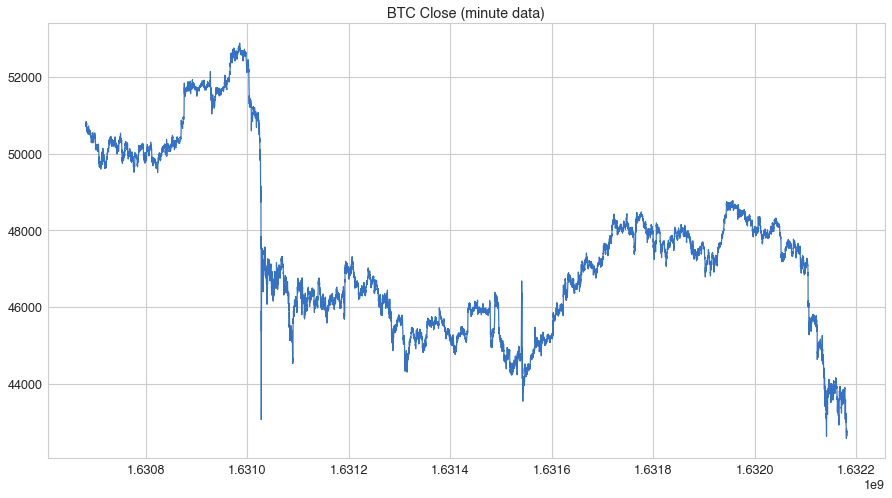

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(btc_mini.Close)
plt.title('BTC Close (minute data)')
plt.grid(True)
plt.show()

# Exponential smoothing

In [23]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), c="orange", label="Alpha {}".format(alpha))
    plt.plot(series.values, "b", label = "Actual")
    plt.title("Moving Exponential Average\n Alpha = {}".format(alphas))
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(
            series, exponential_smoothing(series, alpha)
        )
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, "black", markersize=10)
        
    plt.legend(loc="best")
    plt.grid(b=True)

225 lower-bound anomalies found
225 upper-bound anomalies found


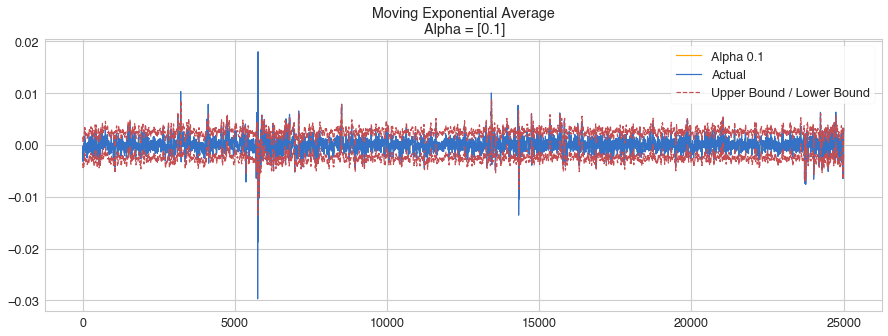

In [54]:
plotExponentialSmoothing(btc_mini.Target, alphas=[0.1], plot_intervals=True, scale=1.96, plot_anomalies=True)

217 lower-bound anomalies found
217 upper-bound anomalies found


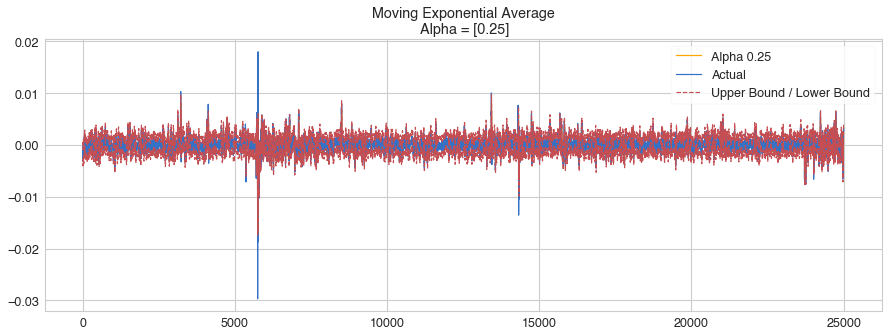

In [55]:
plotExponentialSmoothing(btc_mini.Target, alphas=[0.25], plot_intervals=True, scale=1.96, plot_anomalies=True)

In [ ]:
plotExponentialSmoothing(btc_mini.Target, alphas=[0.5], plot_intervals=True, scale=1.96, plot_anomalies=True)

In [ ]:
plotExponentialSmoothing(btc_mini.Target, alphas=[0.75], plot_intervals=True, scale=1.96, plot_anomalies=True)

213 lower-bound anomalies found
213 upper-bound anomalies found


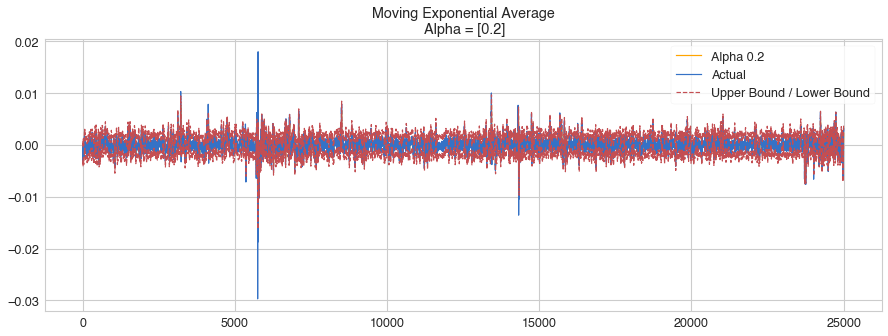

In [52]:
plotExponentialSmoothing(btc_mini.Target, alphas=[0.2], plot_intervals=True, scale=1.96, plot_anomalies=True)

In [25]:
# use
alpha = 0.2

# Econometric Approach

### Stationarity

Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

In [56]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    
    with plt.style.context(style):   
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Alpha={alpha:.4f}\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

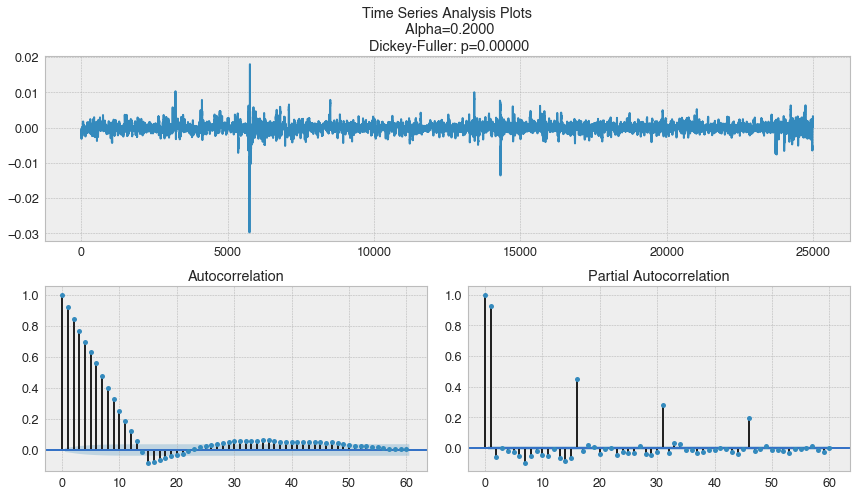

In [57]:
tsplot(btc_mini.Target.values, lags=60)

In [ ]:
# Appears to be stationary
# Autocorrelation chart looks interesting
# There seems to be quite a bit of autocorrelation, which is expected with time-series data
# Let's see ho the Autocorrelation it looks after exponential smoothing

In [ ]:
alphas = np.linspace(start=0.1, stop=0.9, num=9)
for alpha in alphas:

    # btc_mini["Diff1"] = btc_mini.Target - btc_mini.Target.shift(1)
    # btc_mini["Diff2"] = btc_mini["Diff1"] - btc_mini["Diff1"].shift(1)
    # btc_mini["Diff3"] = btc_mini["Diff2"] - btc_mini["Diff2"].shift(1)

    # btc_mini["SmoothedDiff1"] = btc_mini["Smoothed"] - btc_mini["Smoothed"].shift(1)
    # btc_mini["SmoothedDiff2"] = btc_mini["SmoothedDiff1"] - btc_mini["SmoothedDiff1"].shift(1)
    # btc_mini["SmoothedDiff3"] = btc_mini["SmoothedDiff2"] - btc_mini["SmoothedDiff2"].shift(1)
    tsplot(exponential_smoothing(btc_mini.Target, alpha=alpha), lags=50)

In [118]:
%%time
p = 2
d = 0
q = 13

alpha = 0.005
btc_mini["Smoothed"] = exponential_smoothing(btc_mini.Target, alpha=alpha)
data = btc_mini["Smoothed"]

model = statsmodels.tsa.arima.model.ARIMA(endog=data.values, exog=None, order=(p,d,q)).fit()
aic = model.aic

print("AIC: ", aic)

n_steps = 60
actual = np.array(data.values)
arima_model = np.array(model.fittedvalues)
forecast = list(model.predict(start = len(actual), end = len(actual)+n_steps))
forecast = list(arima_model) + forecast

error = mean_absolute_percentage_error(actual, arima_model)

AIC:  -571678.5318774717
CPU times: user 6min 9s, sys: 1min 7s, total: 7min 17s
Wall time: 1min 19s


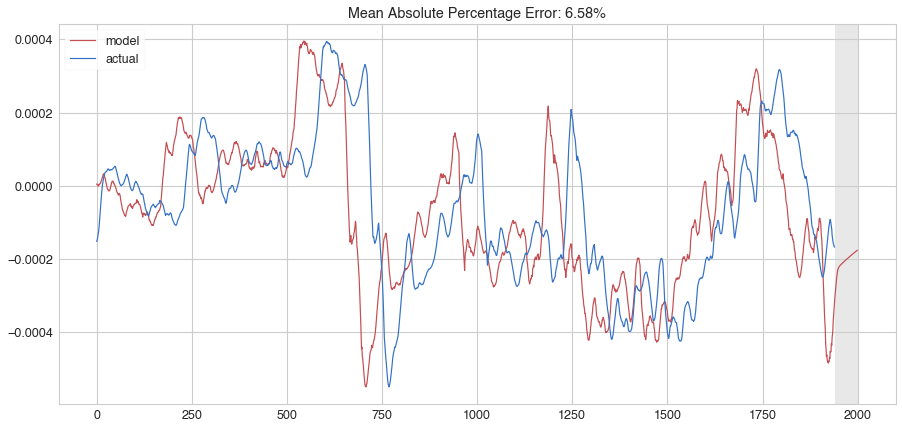

In [119]:
n_steps_to_plot = 2000 # Make sure plot is easy on the eyes

plt.figure(figsize=(15, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(forecast[-n_steps_to_plot:], color='r', label="model")
plt.axvspan(len(forecast[-n_steps_to_plot:])-n_steps, len(forecast[-n_steps_to_plot:]), alpha=0.5, color='lightgrey')
plt.plot(actual[-n_steps_to_plot:-n_steps], label="actual")
plt.legend()
plt.grid(True);

After multiple experiments and models, it has been established that Regression/Boosting techniques are not optimal for this project. It may have to do with XGBoost handling trends poorly when compared to time-series models.

# Regression

In [ ]:
# Lags of time series

In [59]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(btc_mini["Smoothed"].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(2,9):
    data["lag_{}".format(i)] = data.y.shift(i)
    
data.index = pd.to_datetime(data.index, unit="s")

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

gbm = xgboost.XGBRegressor()
gbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", color = "r", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
# Add encoded features

In [64]:
data["hour"] = data.index.hour
data["minute"] = data.index.minute
data.tail()

,y,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,hour,minute
timestamp,,,,,,,,,,
2021-09-20 23:40:00,0.001085,0.000616,0.000255,0.000161,-0.000306,-0.000413,-0.000573,-0.001123,23,40
2021-09-20 23:41:00,0.001517,0.000836,0.000616,0.000255,0.000161,-0.000306,-0.000413,-0.000573,23,41
2021-09-20 23:42:00,0.001836,0.001085,0.000836,0.000616,0.000255,0.000161,-0.000306,-0.000413,23,42
2021-09-20 23:43:00,0.002023,0.001517,0.001085,0.000836,0.000616,0.000255,0.000161,-0.000306,23,43
2021-09-20 23:44:00,0.002163,0.001836,0.001517,0.001085,0.000836,0.000616,0.000255,0.000161,23,44


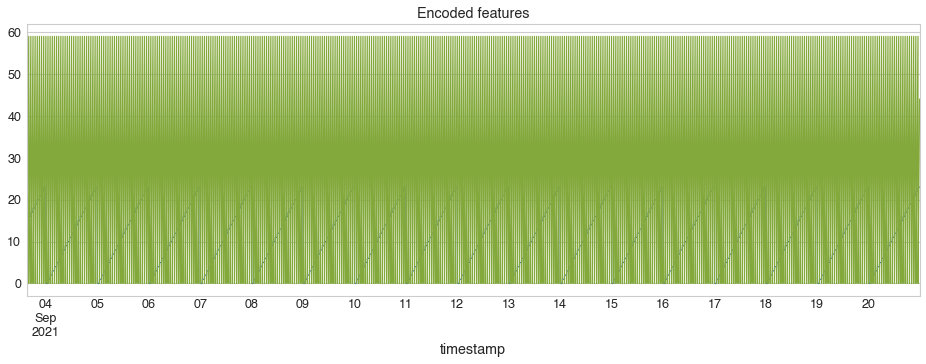

In [65]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.minute.plot()
plt.grid(True);

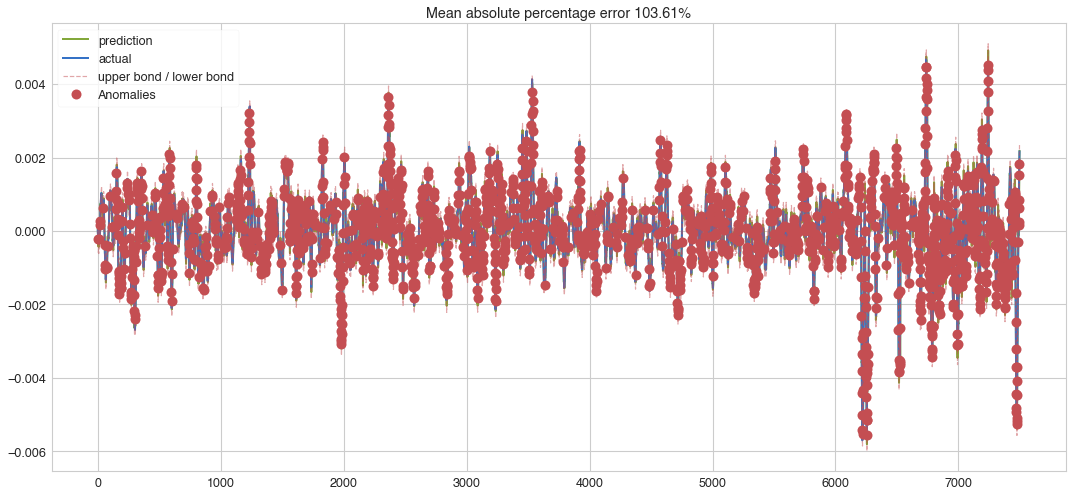

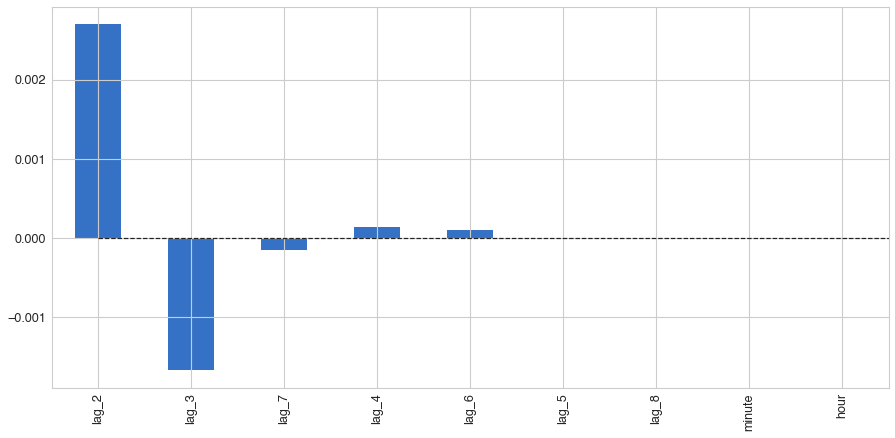

In [66]:
# With scaling
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [40]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

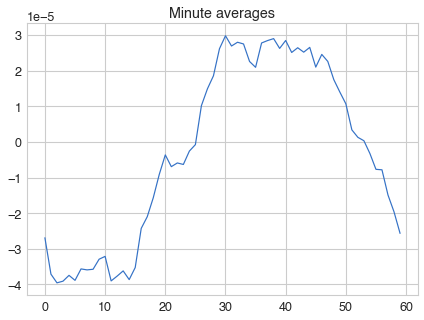

In [41]:
average_hour = code_mean(data, 'minute', "y")
plt.figure(figsize=(7, 5))
plt.title("Minute averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [78]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index, unit="s")
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))
        data["minute_average"] = list(map(code_mean(data[:test_index], 'minute', "y").get, data.minute))

        # frop encoded variables 
        data.drop(["hour", "minute"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [79]:
X_train, X_test, y_train, y_test =\
prepareData(btc_mini.Target, lag_start=2, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

gbm = xgboost.XGBRegressor()
gbm.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

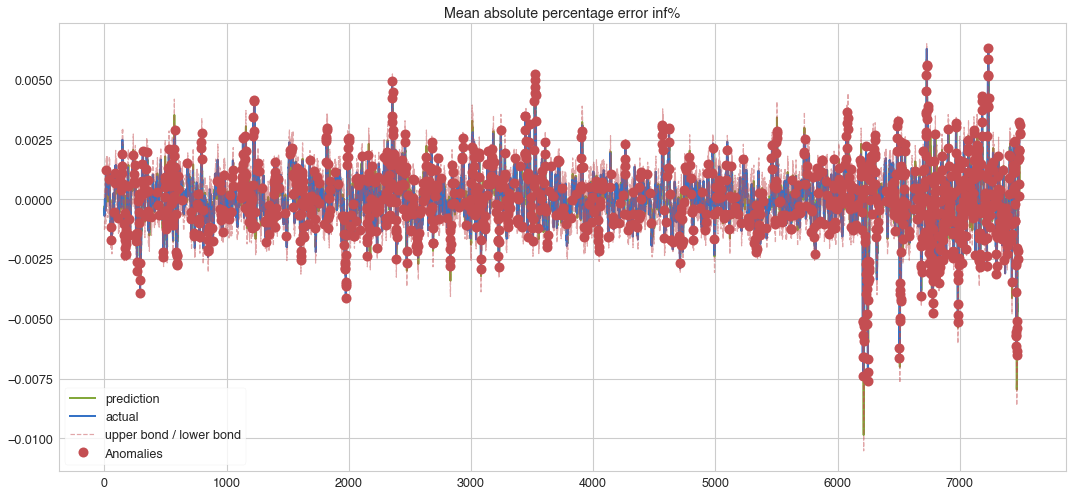

In [82]:
plotModelResults(gbm, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
#plotCoefficients(gbm)